# DEVSIM TCAD simulator

[DEVSIM](https://devsim.org/) is an open-source semiconductor device simulator; also see [publication](https://joss.theoj.org/papers/10.21105/joss.03898). 

Some of its features include:
* Sharfetter-Gummel discretization of the electron and hole continuity equations
* DC, transient, small-signal AC, and noise solution algorithms
* Solution of 1D, 2D, and 3D unstructured meshes
* Advanced models for mobility and semiclassical approaches for quantum effects
In addition, it operates with a symbolic model evaluation interface, easily allowing new models and their derivatives to be scripted.

There is an active community over at the [DEVSIM forums](https://forum.devsim.org/).

## Meshing

DEVSIM solves equations on unstructured meshes.
It has a built-in 1D and 2D meshing interface, you can solve carrier distributions in waveguide cross-sections.
It also interfaces with GMSH for arbitrary 2D and 3D meshes, which you can use for semiconductor simulations of gdsfactory components.

## Install DEVSIM 

To install DEVSIM you can run `make devsim` from the gdsfactory repo or use the following script.

In [1]:
install = False # Set True to install the first time

if install:
    !mkdir ~/devsim
    !wget -P ~/devsim https://github.com/devsim/devsim/releases/download/v2.1.0/devsim_linux_v2.1.0.tgz
    !tar --directory ~/devsim zxvf ~/devsim/devsim_linux_v2.1.0.tgz
    !tar zxvf ~/devsim/devsim_linux_v2.1.0.tgz --directory ~/devsim
    !python ~/devsim/devsim_linux_v2.1.0/install.py
    import sys
    !{sys.executable} -m pip install -e ~/devsim/devsim_linux_v2.1.0/lib # Works in this specific way
    %conda install --yes -c conda-forge pyvista

## DC Drift-diffusion simulation

### Setup

You can setup the simulation by defining a strip waveguide cross-section. 
You can change waveguide geometry (core thickness, slab thickness, core width), doping configuration (dopant level, dopant positions), as well as hyperparameters like adaptive mesh resolution at all the interfaces.

In [2]:
%%capture
from gdsfactory.simulation.devsim import get_simulation_xsection

nm = 1E-9

c = get_simulation_xsection.PINWaveguide(
    wg_width=500 * nm,
    wg_thickness=220 * nm,
    slab_thickness=90 * nm,
)

# Initialize mesh and solver
c.ddsolver()

You can save the device to a tecplot file named `filename.dat` with `c.save_device(filename=filename.dat)`, and then open with [Paraview](https://www.paraview.org/). 

You can also plot the mesh in the Notebook with the `plot` method. By default it shows the geometry.
You can also pass a string to `scalars` to plot a field as color over the mesh.
For instance, acceptor concentration and donor concentration for the PN junction.

`list_fields()` returns the header of the mesh, which lists all possible fields.

In [3]:
c.list_fields()

Header Data Arrays 
 
 UnstructuredGrid Information 
 N Cells 8424 
 N Points 4401 
 X Bounds -2.478e-05, 2.511e-05 
 Y Bounds 9.000e-06, 2.200e-05 
 Z Bounds 0.000e+00, 0.000e+00 
 N Arrays 98 
 

 
 
 Name Field Type N Comp Min Max 
 Acceptors Points float32 1 0.000e+00 1.000e+17 
 AtContactNode Points float32 1 0.000e+00 0.000e+00 
 ContactSurfaceArea Points float32 1 0.000e+00 0.000e+00 
 Donors Points float32 1 0.000e+00 1.000e+17 
 ElectronGeneration Points float32 1 3.408e-26 1.179e-19 
 ElectronGeneration:Electrons Points float32 1 -1.600e-14 -1.600e-28 
 ElectronGeneration:Holes Points float32 1 -1.600e-14 -1.600e-28 
 Electrons Points float32 1 1.000e+03 1.000e+17 
 Electrons_prev Points float32 1 1.000e+10 1.000e+10 
 HoleGeneration Points float32 1 -1.179e-19 -3.408e-26 
 HoleGeneration:Electrons Points float32 1 1.600e-28 1.600e-14 
 HoleGeneration:Holes Points float32 1 1.600e-28 1.600e-14 
 Holes Points float32 1 1.000e+03 1.000e+17 
 Holes_prev Points float32 1 1.000e+10 1.000e+10 
 IntrinsicCharge Points float32 1 -1.000e+17 1.000e+17 
 IntrinsicCharge:Potential Points float32 1 -3.863e+18 -7.736e+11 
 IntrinsicElectrons Points float32 1 1.000e+03 1.000e+17 
 IntrinsicElectrons:Potential Points float32 1 3.863e+04 3.863e+18 
 IntrinsicHoles Points float32 1 1.000e+03 1.000e+17 
 IntrinsicHoles:Potential Points float32 1 -3.863e+18 -3.863e+04 
 NCharge Points float32 1 -1.600e-02 -1.600e-16 
 NCharge:Electrons Points float32 1 -1.600e-19 -1.600e-19 
 NSurfaceNormal_x Points float32 1 0.000e+00 0.000e+00 
 NSurfaceNormal_y Points float32 1 -1.000e+00 0.000e+00 
 NetDoping Points float32 1 -1.000e+17 1.000e+17 
 NodeVolume Points float32 1 7.631e-15 6.522e-13 
 PCharge Points float32 1 1.600e-16 1.600e-02 
 PCharge:Holes Points float32 1 1.600e-19 1.600e-19 
 Potential Points float32 1 -4.173e-01 4.173e-01 
 PotentialIntrinsicCharge Points float32 1 -1.600e-02 1.600e-02 
 PotentialIntrinsicCharge:Potential Points float32 1 1.238e-07 6.181e-01 
 PotentialNodeCharge Points float32 1 -1.600e-02 1.600e-02 
 PotentialNodeCharge:Electrons Points float32 1 1.600e-19 1.600e-19 
 PotentialNodeCharge:Holes Points float32 1 -1.600e-19 -1.600e-19 
 Potential_prev Points float32 1 0.000e+00 0.000e+00 
 SurfaceArea Points float32 1 0.000e+00 6.856e-07 
 USRH Points float32 1 -7.368e-01 -2.130e-07 
 USRH:Electrons Points float32 1 1.000e-09 1.000e+05 
 USRH:Holes Points float32 1 1.000e-09 1.000e+05 
 contactcharge_node Points float32 1 0.000e+00 0.000e+00 
 coordinate_index Points float32 1 5.148e+03 1.246e+04 
 leftnodeelectrons Points float32 1 0.000e+00 0.000e+00 
 leftnodeelectrons:Electrons Points float32 1 0.000e+00 0.000e+00 
 leftnodeholes Points float32 1 0.000e+00 0.000e+00 
 leftnodeholes:Holes Points float32 1 0.000e+00 0.000e+00 
 leftnodemodel Points float32 1 0.000e+00 0.000e+00 
 leftnodemodel:Potential Points float32 1 0.000e+00 0.000e+00 
 node_index Points float32 1 0.000e+00 4.400e+03 
 rightnodeelectrons Points float32 1 0.000e+00 0.000e+00 
 rightnodeelectrons:Electrons Points float32 1 0.000e+00 0.000e+00 
 rightnodeholes Points float32 1 0.000e+00 0.000e+00 
 rightnodeholes:Holes Points float32 1 0.000e+00 0.000e+00 
 rightnodemodel Points float32 1 0.000e+00 0.000e+00 
 rightnodemodel:Potential Points float32 1 0.000e+00 0.000e+00 
 Bern01 Points float32 1 1.000e+00 1.187e+00 
 Bern01:Potential@n0 Points float32 1 -2.368e+01 -1.663e+01 
 Bern01:Potential@n1 Points float32 1 1.663e+01 2.368e+01 
 EdgeCouple Points float32 1 6.908e-08 5.446e-07 
 EdgeInverseLength Points float32 1 1.101e+06 9.710e+06 
 EdgeLength Points float32 1 1.399e-07 9.389e-07 
 EdgeNodeVolume Points float32 1 1.908e-15 1.087e-13 
 ElectricField Points float32 1 -6.838e+04 -2.951e-04 
 ElectricField:Potential@n0 Points float32 1 1.101e+06 9.710e+06 
 ElectricField:Potential@n1 Points float32 1 -9.710e+06 -1.101e+06 
 ElectronCurrent Points float32 1 -3.852e-10 3.129e-10 
 ElectronCurrent:Electrons@n0 Points float32 1 -1.822e-11 -1.

Finite-element field information can be plotted using pyvista (note that lengths in DEVSIM are cm by default):

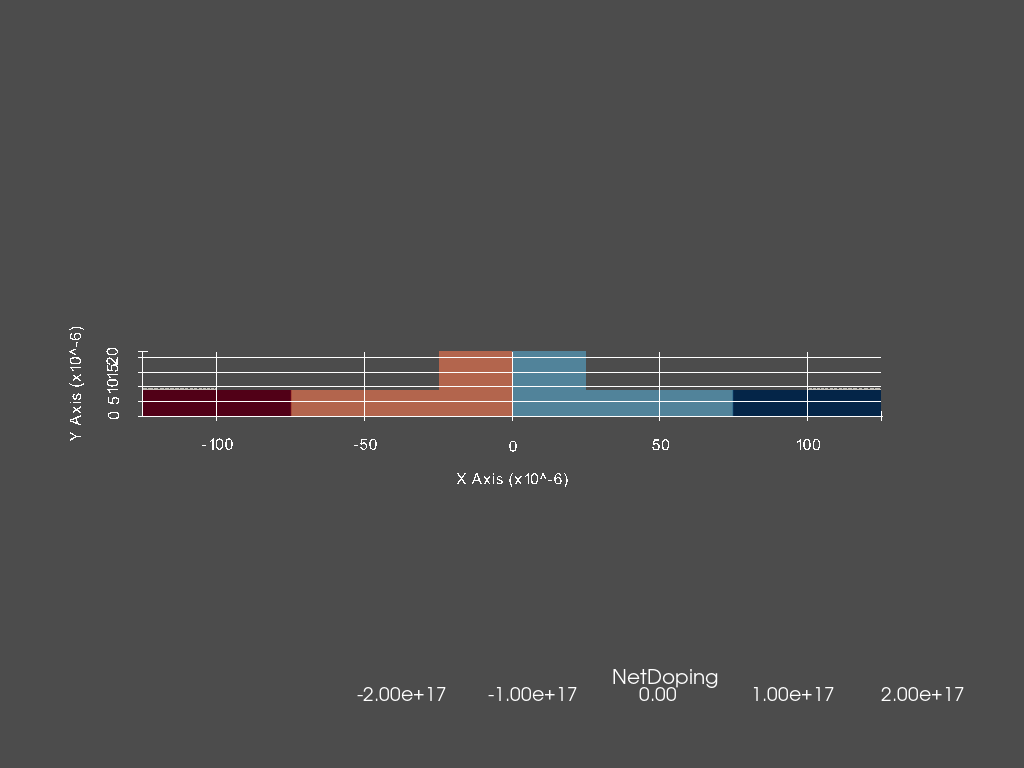

In [4]:
c.plot(scalars='NetDoping')

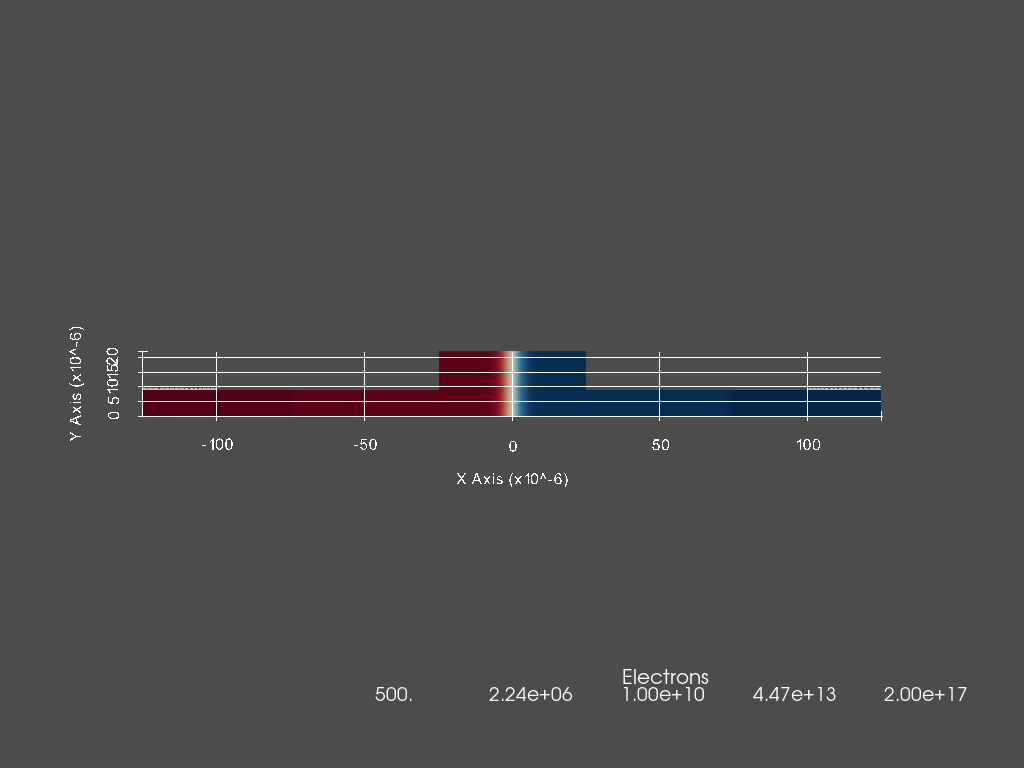

In [5]:
c.plot(scalars='Electrons', log_scale=True)

### Solve

Using default DEVSIM silicon models, we iteratively solve for the self-consistent carrier distribution for 0.5V of applied forward voltage, iterating with 0.1V steps, and then visualize the electron concentration:

In [6]:
%%capture
# Find a solution with 1V across the junction, ramping by 0.1V steps
c.ramp_voltage(Vfinal=0.5, Vstep=0.1)

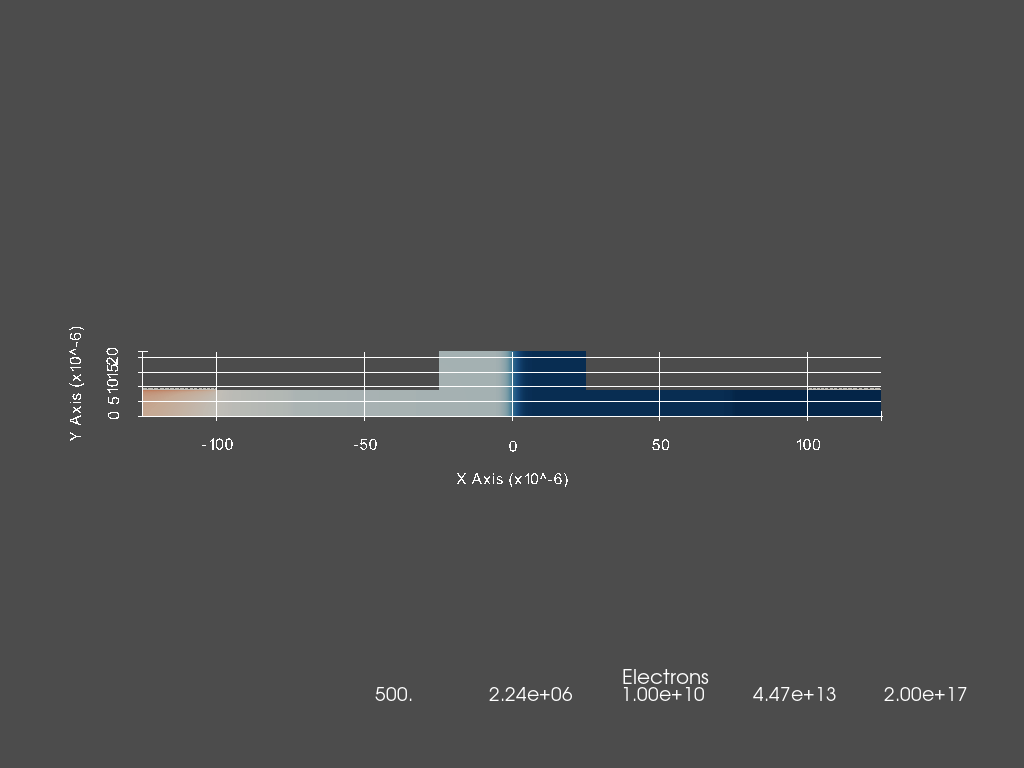

In [7]:
c.plot(scalars='Electrons', log_scale=True)

and similarly for reverse-bias: 

In [8]:
%%capture
c.ramp_voltage(Vfinal=-0.5, Vstep=-0.1)

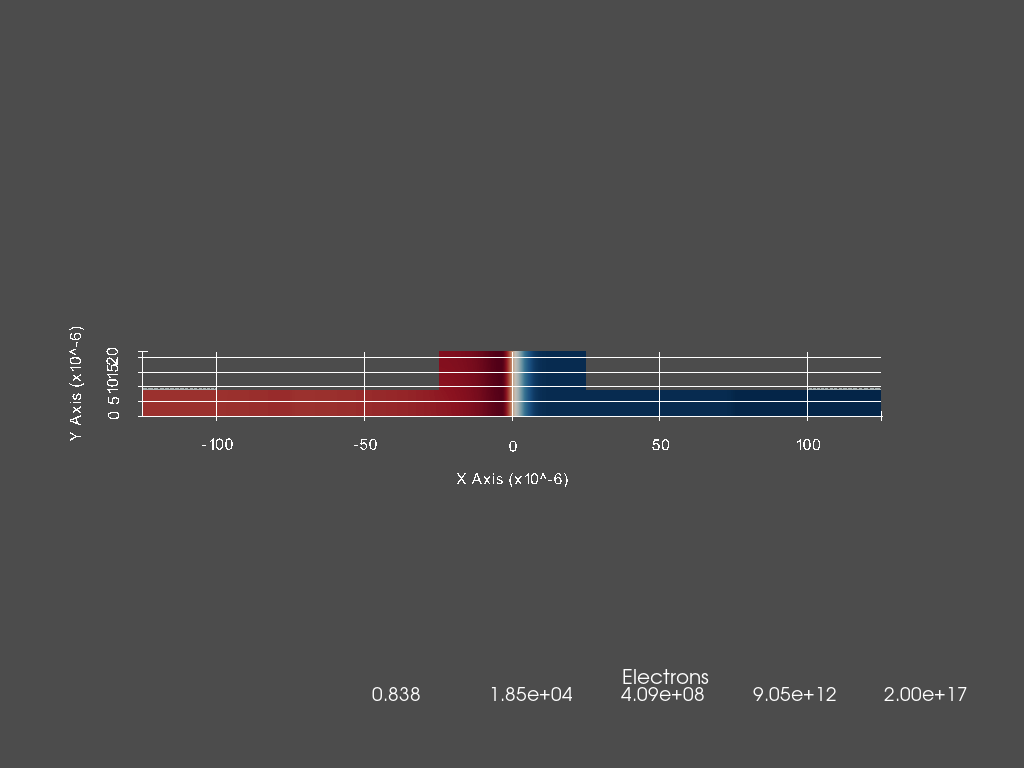

In [9]:
c.plot(scalars='Electrons', log_scale=True)

# Interface to mode solver

The carrier distribution can be used to create a (currently only tidy3d) mode solver object with perturbed index, and to acquire the effective index as a function of applied voltage:

In [10]:
voltages = [0,-0.5,-1,-1.5,-2,-2.5,-3,-3.5,-4]
ramp_rate = -0.1

n_dist = {}
neffs = {}

for ind, voltage in enumerate(voltages):
    if ind == 0:
        Vinit = 0
    else:
        Vinit = voltages[ind-1]

    c.ramp_voltage(Vfinal=voltage, Vstep=ramp_rate, Vinit=Vinit)
    waveguide = c.make_waveguide(wavelength=1.55)
    waveguide.compute_modes(isolate=True) # Isolate flag runs the mode solver in another interpreter, use if solver has issues
    n_dist[voltage] = waveguide.nx
    neffs[voltage] = waveguide.neffs[0]

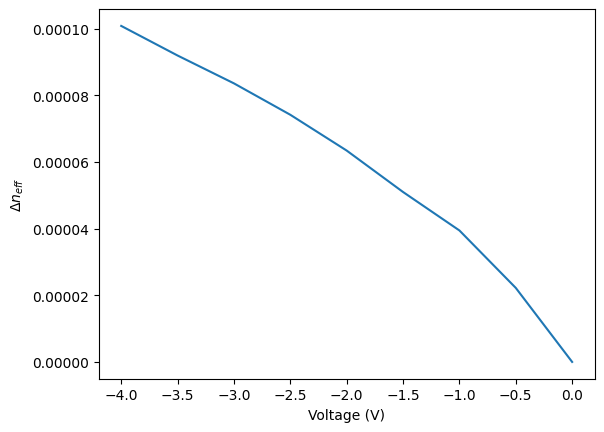

In [16]:
import matplotlib.pyplot as plt
import numpy as np

voltage_list = sorted(neffs.items())
x, y = zip(*voltage_list)

plt.plot(x,np.real(y) - neffs[0])

plt.xlabel("Voltage (V)")
plt.ylabel("$\Delta n_{eff}$")

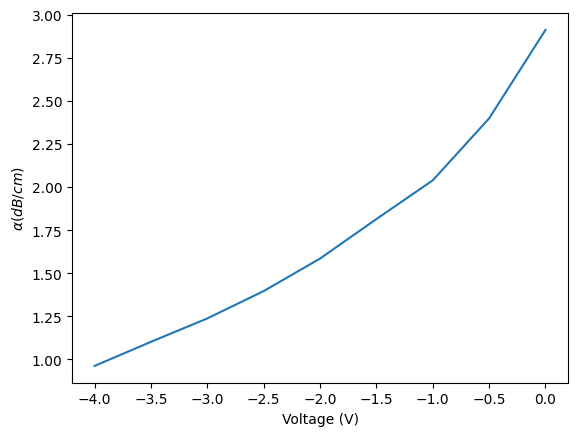

In [17]:
import matplotlib.pyplot as plt
from gdsfactory.simulation.devsim.get_simulation_xsection import k_to_alpha

voltage_list = sorted(neffs.items())
x, y = zip(*voltage_list)

plt.plot(x, -10*np.log10(1-k_to_alpha(np.imag(y), wavelength=1.55)))

plt.xlabel("Voltage (V)")
plt.ylabel(r"$\alpha (dB/cm)$")

We can compare the index distribution the same undoped waveguide:

In [18]:
c_undoped = c.make_waveguide(wavelength=1.55, perturb=False, precision="double")
c_undoped.compute_modes()
n_undoped = c_undoped.nx

/tmp/ipykernel_536908/3660792696.py:2: RuntimeWarning: divide by zero encountered in log
  plt.imshow(np.log(np.abs(np.real(n_dist[0].T - n_undoped.T))),


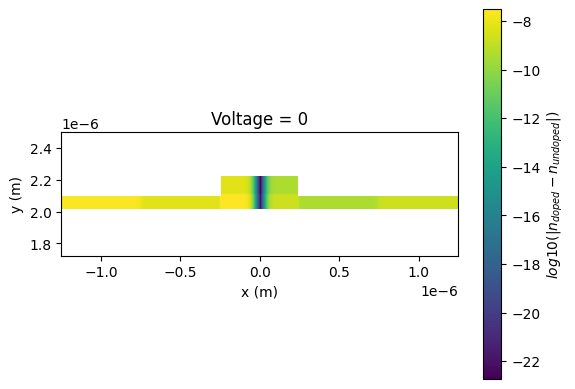

In [21]:
import numpy as np
plt.imshow(np.log(np.abs(np.real(n_dist[0].T - n_undoped.T))), 
                origin='lower', 
                extent=[-c.xmargin - c.ppp_offset - c.wg_width / 2,
                        c.xmargin + c.npp_offset + c.wg_width / 2,
                        0,
                        c.t_clad + c.t_box + c.wg_thickness])
plt.colorbar(label="$log10(|n_{doped} - n_{undoped}|)$")
plt.xlabel("x (m)")
plt.ylabel("y (m)")
plt.ylim(1.72E-6, 2.5E-6)
plt.title("Voltage = 0")

/tmp/ipykernel_536908/3619136160.py:1: RuntimeWarning: divide by zero encountered in log
  plt.imshow(np.log(np.abs(np.real(n_dist[-4].T - n_undoped.T))),


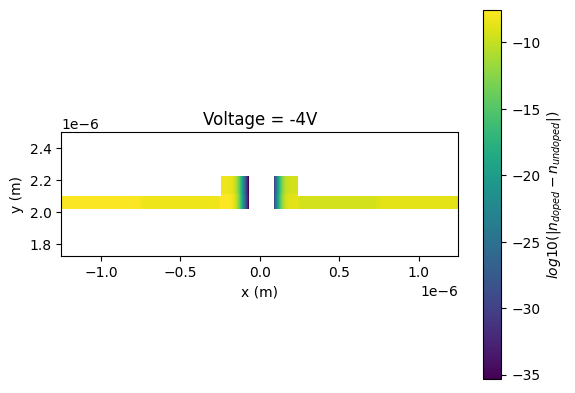

In [22]:
plt.imshow(np.log(np.abs(np.real(n_dist[-4].T - n_undoped.T))), 
                origin='lower', 
                extent=[-c.xmargin - c.ppp_offset - c.wg_width / 2,
                        c.xmargin + c.npp_offset + c.wg_width / 2,
                        0,
                        c.t_clad + c.t_box + c.wg_thickness])
plt.colorbar(label="$log10(|n_{doped} - n_{undoped}|)$")
plt.xlabel("x (m)")
plt.ylabel("y (m)")
plt.ylim(1.72E-6, 2.5E-6)
plt.title("Voltage = -4V")

/tmp/ipykernel_536908/1459716304.py:2: RuntimeWarning: divide by zero encountered in log
  plt.imshow(np.log(np.abs(np.imag(n_dist[0].T - n_undoped.T))),


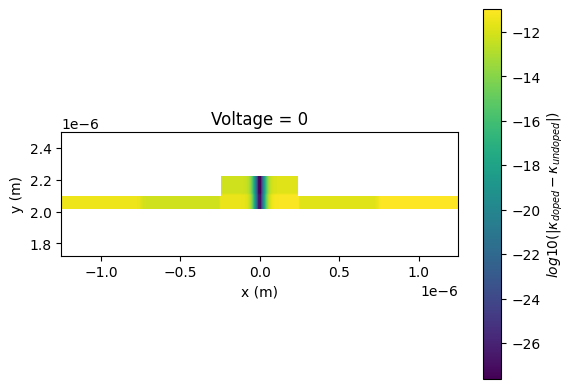

In [28]:
import numpy as np
plt.imshow(np.log(np.abs(np.imag(n_dist[0].T - n_undoped.T))), 
                origin='lower', 
                extent=[-c.xmargin - c.ppp_offset - c.wg_width / 2,
                        c.xmargin + c.npp_offset + c.wg_width / 2,
                        0,
                        c.t_clad + c.t_box + c.wg_thickness])
plt.colorbar(label="$log10(|\kappa_{doped} - \kappa_{undoped}|)$")
plt.xlabel("x (m)")
plt.ylabel("y (m)")
plt.ylim(1.72E-6, 2.5E-6)
plt.title("Voltage = 0")

/tmp/ipykernel_536908/3740399484.py:2: RuntimeWarning: divide by zero encountered in log
  plt.imshow(np.log(np.abs(np.imag(n_dist[-4].T))),


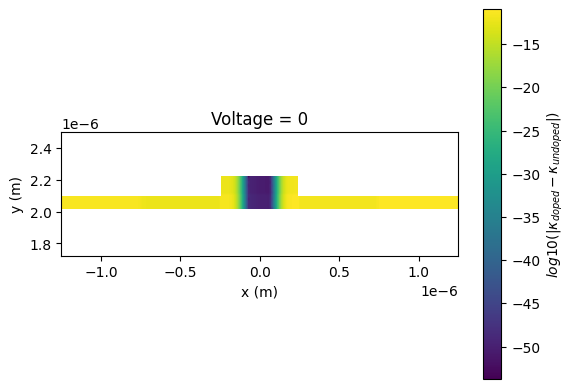

In [30]:
import numpy as np
plt.imshow(np.log(np.abs(np.imag(n_dist[-4].T))), 
                origin='lower', 
                extent=[-c.xmargin - c.ppp_offset - c.wg_width / 2,
                        c.xmargin + c.npp_offset + c.wg_width / 2,
                        0,
                        c.t_clad + c.t_box + c.wg_thickness])
plt.colorbar(label="$log10(|\kappa_{doped} - \kappa_{undoped}|)$")
plt.xlabel("x (m)")
plt.ylabel("y (m)")
plt.ylim(1.72E-6, 2.5E-6)
plt.title("Voltage = 0")